# E-commerce User Action Prediction

In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# load the dataset
df = pd.read_csv(".\Datasets\ecommerce_data.csv", encoding="UTF-8")

In [3]:
df.head()

,is_mobile,n_products_viewed,visit_duration,is_returning_visitor,time_of_day,user_action
0,1,0,0.657510,0,3,0
1,1,1,0.568571,0,2,1
2,1,0,0.042246,1,1,0
3,1,1,1.659793,1,1,2
4,0,1,2.014745,1,1,2


In [4]:
# Check missing values
df.isnull().any()

is_mobile               False
n_products_viewed       False
visit_duration          False
is_returning_visitor    False
time_of_day             False
user_action             False
dtype: bool

In [5]:
# Normalize the n_products_viewed and visit_duration columns
df["n_products_viewed"] = df["n_products_viewed"].mean() / df["n_products_viewed"].std()
df["visit_duration"] = df["visit_duration"].mean() / df["visit_duration"].std()

In [6]:
# input and output features
X = df.iloc[:,:-1].to_numpy()
Y = df.iloc[:,-1].to_numpy()

In [7]:
# Apply one hot encoding to "time_of_day" column
V = np.zeros((X.shape[0], (X[:,-1].max()+1).astype(np.int32)))

for i,j in enumerate(X[:,-1]):
    V[i,int(j)] = 1
    
X = np.concatenate((X[:,:-1].reshape(X.shape[0],X.shape[1]-1),V), axis=1)

In [8]:
# Apply one hot encoding to Y and take as T
T = np.zeros((Y.shape[0], np.unique(Y).shape[0]))

for i,j in enumerate(Y):
    T[i,j] = 1

In [9]:
print(X.shape, T.shape)

(500, 8) (500, 4)


In [10]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [11]:
def tanh(z):
    return (np.exp(z)-np.exp(-z)) / (np.exp(z)+np.exp(-z))

In [123]:
def softmax(z):
    return np.exp(z) / np.sum(np.exp(z),axis=1,keepdims=True)

In [45]:
def cost(T,Y):
    L = -np.mean(T*np.log(Y))
    return L

In [14]:
def predict(output):
    predictions = np.argmax(output, axis=1) # Return the index of the highest probability value
    return predictions

In [15]:
def accuracy(y, yhat):
    return np.mean(y==yhat)

In [111]:
def forwardProp(X,T,W,B,A,hidden_units, activation_func, iteration, random_state):
    D = X.shape[1] # N.Input Features
    L = len(hidden_units) # N.Hidden Layers
    K = T.shape[1] # N.Outputs
    np.random.seed(random_state) # Seed
    
    for i in range(L+1): # Iterate until reach Output layer
        if i == 0: # At First Hidden Layer
            if iteration == 0:
                W[i] = np.random.randn(D,hidden_units[0]) # Weights Initialization DxM
                B[i] = np.random.randn(hidden_units[0]) # Bias Initialization M
            z1 = np.dot(X,W[i])+B[i] # Dot with W
            A[i] = activation_func(z1) # Apply Activation Func
            
        elif i == L: # At output layer
            if iteration == 0:
                W[i] = np.random.randn(hidden_units[i-1],K)
                B[i] = np.random.randn(K)
            z2 = np.dot(A[i-1],W[i])+B[i]
            A[i] = softmax(z2) # softmax
            
        else: # At Middle Hidden Layers
            if iteration == 0:
                W[i] = np.random.randn(hidden_units[i-1],hidden_units[i])
                B[i] = np.random.randn(hidden_units[i])
            z3 = np.dot(A[i-1],W[i])+B[i]
            A[i] = activation_func(z3)
    
    return W, B, A, A[len(A.keys())-1] # last layer

In [112]:
def backProp(X,T,Y,W,B,A,hidden_units,activation_func, lr):
    L = len(hidden_units) # N.Hidden Layers
    Error, delta = {}, {}
    
    for i in range(L,-1,-1):
        if i == L: # At output layer
            Error[i] = T-Y # error
            delta[i] = Error[i]
            W[i] += lr*np.dot(A[i-1].T,delta[i])
            B[i] += lr*delta[i].sum()
            
        elif i == 0: # At First Hidden Layer
            Error[i] = np.dot(delta[i+1], W[i+1].T)
            delta[i] = Error[i]*(1-A[i]**2)
            W[i] += lr*np.dot(X.T,delta[i])
            B[i] += lr*delta[i].sum()
            
        else: # At Middle Hidden Layers
            Error[i] = np.dot(delta[i+1], W[i+1].T)
            delta[i] = Error[i]*(1-A[i]**2)
            W[i] += lr*np.dot(A[i-1].T,delta[i])
            B[i] += lr*delta[i].sum()
            
    return W,B

In [126]:
def fit(X, T, hidden_units=[8], lr=0.01, iterations=100, activation_func=sigmoid, random_state=1):
    C = [] # Total Cost
    W, B, A = {}, {}, {} # Weights, Biases, Activation-Output
    
    for i in range(iterations):      
        W, B, A, Y = forwardProp(X,T,W,B,A,hidden_units,activation_func, i, random_state) # Forward Propagation
        W, B = backProp(X,T,Y,W,B,A,hidden_units,activation_func, lr) # Backpropagation
        C.append(cost(T,Y)) # Cost
        
    Yhat = predict(Y) # Prediction
        
    return C, Yhat

In [136]:
# X = Input
# T = Target
# hidden_units = list(num,of,neurons,in,Each,layer)
# lr = Learning Rate
# iterations
# activation_func = sigmoid/tanh/relu
# random_state = seed

c, Yhat = fit(X,T,hidden_units=[10], lr=0.001, iterations=10000, activation_func=tanh, random_state=1)

In [137]:
# accuracy
results = accuracy(Y, Yhat)
print("Accuracy: ", str(results*100))

Accuracy:  51.6


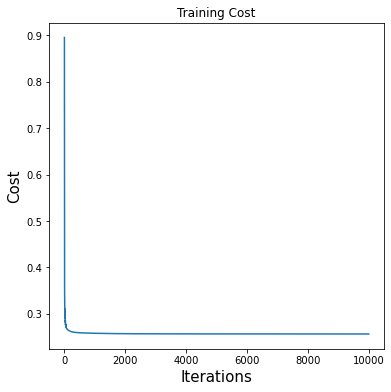

In [138]:
plt.figure(figsize=(6,6))
plt.plot(c)
plt.title("Training Cost")
plt.xlabel("Iterations", fontsize=15)
plt.ylabel("Cost", fontsize=15)
plt.show()

In [82]:
Y

array([0, 1, 0, 2, 2, 2, 0, 0, 1, 0, 3, 0, 0, 1, 0, 3, 1, 1, 1, 0, 2, 0,
       0, 3, 0, 1, 0, 0, 2, 2, 0, 1, 2, 2, 1, 0, 0, 1, 1, 0, 2, 1, 0, 1,
       3, 0, 1, 0, 0, 1, 2, 3, 1, 2, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 3, 0, 2, 1, 1, 3, 1, 0, 3, 0, 2, 0, 2, 0, 1, 0, 1, 0, 0, 1, 0,
       2, 3, 1, 0, 0, 1, 0, 0, 1, 0, 2, 0, 1, 0, 1, 1, 2, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 1, 2, 1, 2, 0, 2, 2, 0, 2,
       2, 0, 0, 0, 3, 1, 1, 1, 0, 0, 1, 1, 0, 2, 0, 0, 0, 0, 0, 2, 0, 1,
       0, 1, 0, 0, 0, 2, 0, 1, 0, 2, 1, 1, 0, 1, 2, 0, 0, 0, 0, 3, 0, 1,
       0, 0, 0, 0, 1, 0, 3, 0, 2, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 3, 3,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 2, 0,
       0, 1, 2, 0, 2, 0, 0, 1, 3, 1, 2, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 3, 0, 0, 1, 0, 2, 2, 1, 0, 2, 0, 0, 3, 2, 1, 0, 3, 0, 0, 1,
       0, 2, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0,

In [125]:
Yhat

array([[0.37156515, 0.10164932, 0.41720793, 0.10957761],
       [0.44982641, 0.14734287, 0.27712894, 0.12570178],
       [0.56580536, 0.16985102, 0.17183161, 0.09251201],
       ...,
       [0.49805567, 0.44952051, 0.01001311, 0.04241072],
       [0.37156515, 0.10164932, 0.41720793, 0.10957761],
       [0.49805567, 0.44952051, 0.01001311, 0.04241072]])